In [3]:
import pandas as pd
import networkx as nx

# Load airport data
airports_df = pd.read_csv("./CSVFiles/airports.csv")  # Contains Airport ID, IATA, Name, Country
routes_df = pd.read_csv("./CSVFiles/routes.csv")  # Contains Source airport, Destination airport

# Filter for US and Canada airports
US_Canada_Airports = airports_df[airports_df["Country"].isin(["United States"])]

# Map IATA codes to airport names
airport_name_map = dict(zip(US_Canada_Airports["IATA"], US_Canada_Airports["Name"]))

# Keep only flights where both airports are in US/Canada
filtered_flights = routes_df[
    (routes_df["Source airport"].isin(airport_name_map)) & 
    (routes_df["Destination airport"].isin(airport_name_map))
]

# Normalize flight direction (ensuring undirected edges)
filtered_flights["Route"] = filtered_flights.apply(lambda row: tuple(sorted([row["Source airport"], row["Destination airport"]])), axis=1)

# Count occurrences of each unique route (weight)
route_counts = filtered_flights["Route"].value_counts().reset_index()
route_counts.columns = ["Route", "Weight"]

# Split back into Source and Target
route_counts[["Source", "Target"]] = pd.DataFrame(route_counts["Route"].tolist(), index=route_counts.index)

# Create a Graph
G = nx.Graph()

# Add edges with weight
for _, row in route_counts.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Weight"])
    G.add_node(row["Source"], label = row["Source"])
# Save as GEXF (supported by Gephi)
nx.write_gexf(G, "FinalProject.gexf")

print("Filtered graph file created: FinalProject.gexf")


Filtered graph file created: FinalProject.gexf


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16876\1141897688.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_flights["Route"] = filtered_flights.apply(lambda row: tuple(sorted([row["Source airport"], row["Destination airport"]])), axis=1)


In [5]:
import pandas as pd

# Load full airport data with lat/lon
df_all = pd.read_csv('./CSVFiles/airports.csv')

# Load your working subset
df_subset = pd.read_csv('./CSVFiles/ModularityTable.csv')

# Merge: keep all columns from subset, just bring lat/lon from full dataset
df_merged = df_subset.merge(
    df_all[['IATA', 'Latitude', 'Longitude']],
   left_on='Label',   # column in ModularityTable.csv
    right_on='IATA',    # Replace with the correct join key (like 'Name' or 'ICAO')
    how='left'
)

# Save to CSV
df_merged.to_csv('airports_with_coordinates.csv', index=False)


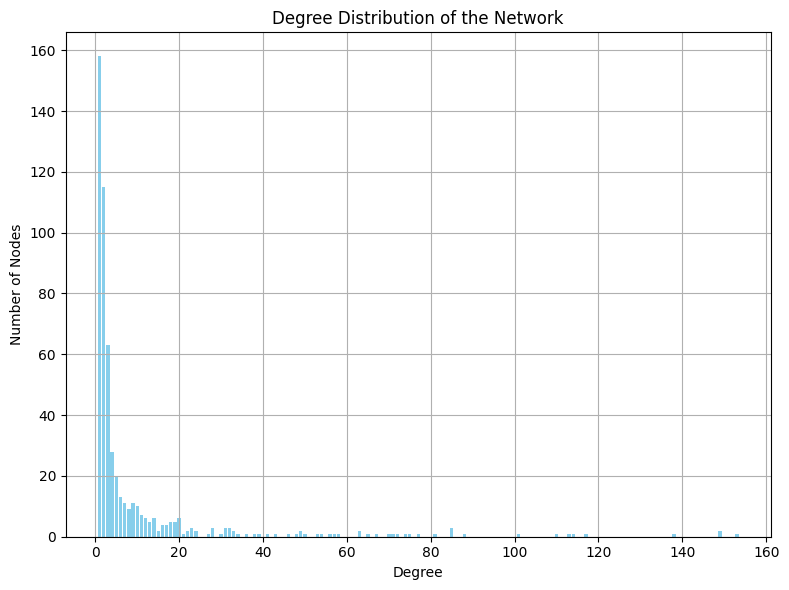

In [10]:
def plot_degree_distribution(G):
    degrees = [d for n, d in G.degree()]
    unique_degrees = list(set(degrees))
    degree_count = [degrees.count(k) for k in unique_degrees]

    plt.figure(figsize=(8, 6))
    plt.bar(unique_degrees, degree_count, width=0.80, color='skyblue')
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.title("Degree Distribution of the Network")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
G = nx.read_graphml("Output.graphml") 
G = G.to_undirected()

# Plot the degree distribution
plot_degree_distribution(G)

In [11]:
density = nx.density(G)
print(f"Network Density: {density}")

Network Density: 0.01852738223445415


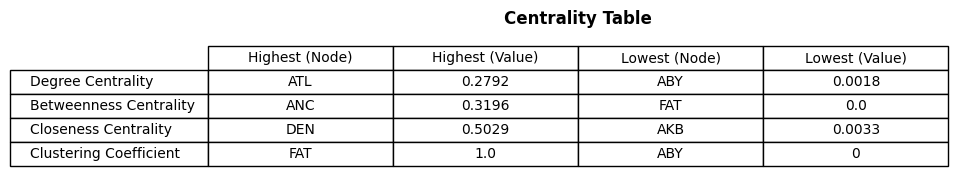

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- Centrality Summary Function ---
def centrality_extremes(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    Clustering = nx.clustering(G)
    def get_extremes(centrality_dict):
        max_node = max(centrality_dict, key=centrality_dict.get)
        min_node = min(centrality_dict, key=centrality_dict.get)
        return {
            "Highest (Node)": max_node,
            "Highest (Value)": round(centrality_dict[max_node], 4),
            "Lowest (Node)": min_node,
            "Lowest (Value)": round(centrality_dict[min_node], 4),
        }

    result = {
        "Degree Centrality": get_extremes(degree_centrality),
        "Betweenness Centrality": get_extremes(betweenness_centrality),
        "Closeness Centrality": get_extremes(closeness_centrality),
        "Clustering Coefficient" : get_extremes(Clustering),
    }

    df = pd.DataFrame(result).T
    return df

# --- Table Plotting Function ---
def plot_table_as_image(df, output_path="centrality_table.png"):
    fig, ax = plt.subplots(figsize=(10, 2))  # Adjust size for content
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     loc='center',
                     cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.title("Analysis Table", fontsize=12, weight='bold')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


G = G.to_undirected()

# Generate DataFrame
df_centrality = centrality_extremes(G)

# Create and save table image
plot_table_as_image(df_centrality)


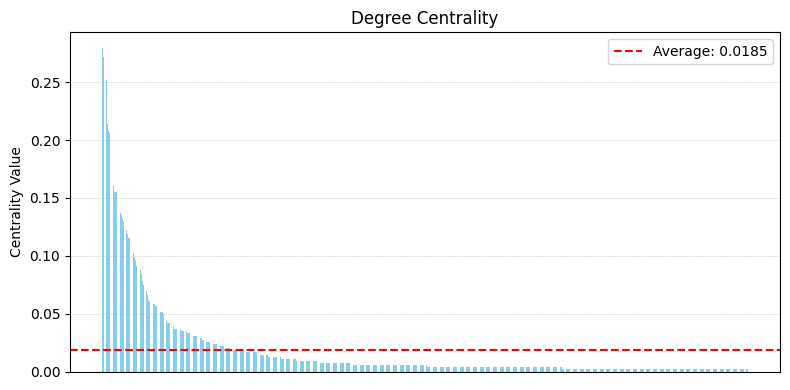

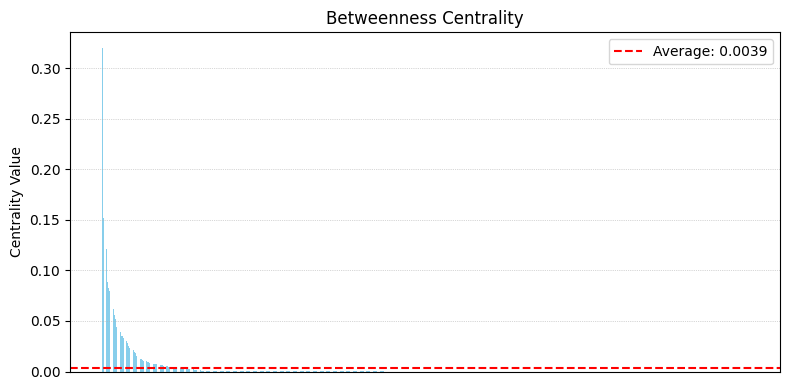

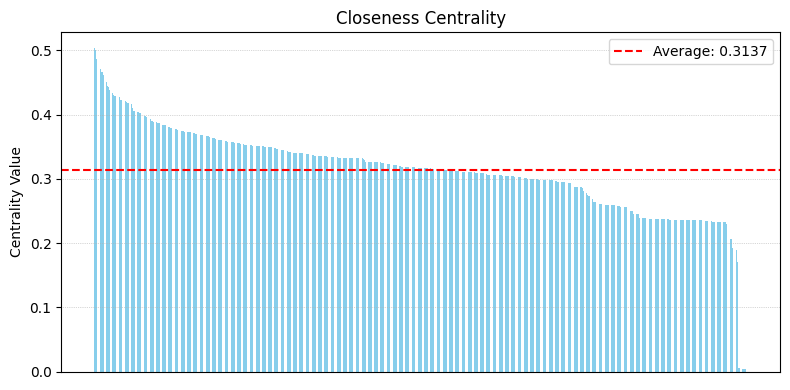

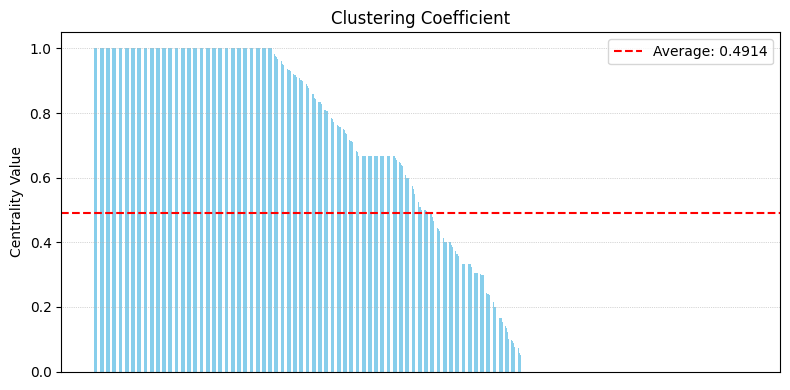

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

def compute_all_centralities(G):
    return {
        "Degree Centrality": nx.degree_centrality(G),
        "Betweenness Centrality": nx.betweenness_centrality(G),
        "Closeness Centrality": nx.closeness_centrality(G),
        "Clustering Coefficient" : nx.clustering(G),
    }

def plot_compact_centrality_graphs(centralities, use_labels=False):
    for name, centrality in centralities.items():
        sorted_items = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        nodes = [item[0] for item in sorted_items]
        values = [item[1] for item in sorted_items]
        avg = sum(values) / len(values)

        x_ticks = nodes if use_labels and len(nodes) <= 30 else range(len(nodes))

        plt.figure(figsize=(8, 4))
        plt.bar(x_ticks, values, color='skyblue', width=0.6)
        plt.axhline(avg, color='red', linestyle='--', linewidth=1.5, label=f'Average: {avg:.4f}')
        plt.title(f'{name}')
        plt.ylabel('Centrality Value')
        if use_labels and len(nodes) <= 30:
            plt.xticks(rotation=90)
        else:
            plt.xticks([])  # suppress x-tick labels if too many
        plt.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle=':', linewidth=0.5)
        plt.show()

# Load your graph
G = G.to_undirected()

# Compute and plot compact graphs
centralities = compute_all_centralities(G)
plot_compact_centrality_graphs(centralities)


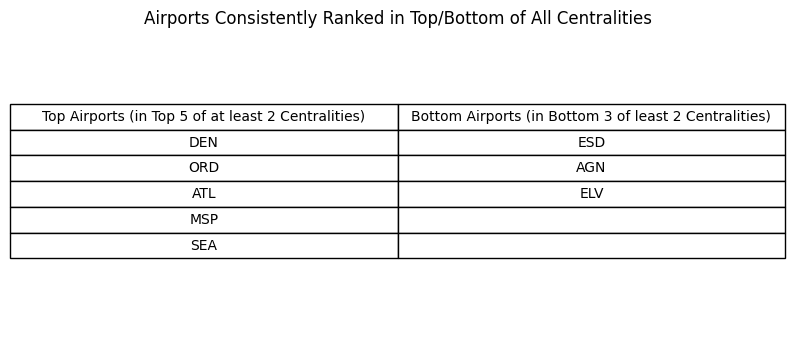

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute Centralities
def compute_all_centralities(G):
    return {
        "Degree": nx.degree_centrality(G),
        "Betweenness": nx.betweenness_centrality(G),
        "Closeness": nx.closeness_centrality(G),
    }

# Step 2: Find Consistent Top and Bottom Airports
def find_top_bottom_airports_relaxed(G, top_n=5, min_hits=2):
    centralities = {
        "Degree": nx.degree_centrality(G),
        "Betweenness": nx.betweenness_centrality(G),
        "Closeness": nx.closeness_centrality(G),
    }

    top_counts = {}
    bottom_counts = {}

    for _, cent in centralities.items():
        sorted_nodes = sorted(cent.items(), key=lambda x: x[1], reverse=True)
        for node, _ in sorted_nodes[:top_n]:
            top_counts[node] = top_counts.get(node, 0) + 1
        for node, _ in sorted_nodes[-top_n:]:
            bottom_counts[node] = bottom_counts.get(node, 0) + 1

    # Accept nodes that appear in top/bottom at least `min_hits` times
    top_final = sorted([node for node, count in top_counts.items() if count >= min_hits],
                       key=lambda x: -sum(centralities[k][x] for k in centralities))[:top_n]
    bottom_final = sorted([node for node, count in bottom_counts.items() if count >= min_hits],
                          key=lambda x: sum(centralities[k][x] for k in centralities))[:top_n]

    return top_final, bottom_final


# Step 3: Plot as an Image Table
def plot_airport_table_image(top_airports, bottom_airports, output_path="centrality_extremes.png"):
    top_list = [a[0] for a in top_airports]
    bottom_list = [a[0] for a in bottom_airports]

    # Pad lists to equal length
    max_len = max(len(top_list), len(bottom_list))
    top_list += [""] * (max_len - len(top_list))
    bottom_list += [""] * (max_len - len(bottom_list))

    # Create table
    df = pd.DataFrame({
        "Top Airports (in Top 5 of at least 2 Centralities)": top_list,
        "Bottom Airports (in Bottom 3 of least 2 Centralities)": bottom_list
    })

    # Plot table as image
    fig, ax = plt.subplots(figsize=(8, 2 + max_len * 0.3))
    ax.axis('off')
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.4)
    plt.title("Airports Consistently Ranked in Top/Bottom of All Centralities", fontsize=12)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


# Step 4: Run All
G = G.to_undirected()

top_airports, bottom_airports = find_top_bottom_airports_relaxed(G, top_n=5, min_hits=2)
plot_airport_table_image([(a, 0) for a in top_airports], [(a, 0) for a in bottom_airports])



In [28]:
import networkx as nx

# Your graph
G = G.to_undirected()

# Generate comparable random graph
n = G.number_of_nodes()
p = nx.density(G)  # probability for Erdos-Renyi model
G_rand = nx.erdos_renyi_graph(n, p)

# Real metrics
C_real = nx.average_clustering(G)
# Use the largest connected component for path length metrics
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
else:
    G_sub = G

# Now safely compute
L_real = nx.average_shortest_path_length(G_sub)

# Random graph metrics
C_rand = nx.average_clustering(G_rand)
L_rand = nx.average_shortest_path_length(G_rand)

# Small-world coefficient
sigma = (C_real / C_rand) / (L_real / L_rand)

print(f"Small-world coefficient (σ): {sigma:.3f}")
if sigma > 1:
    print("✅ Network exhibits small-world properties.")
else:
    print("❌ Network is not small-world.")


Small-world coefficient (σ): 23.787
✅ Network exhibits small-world properties.
